## **Load in data**

In [1]:
! rm -r AIMS-DEI
! git clone https://github.com/alex-stephens/AIMS-DEI.git
! if test ! -f "GP.py"; then mv AIMS-DEI/GP.py .; fi
! if test ! -f "data.py"; then mv AIMS-DEI/data.py .; fi
! if test ! -f "vis.py"; then mv AIMS-DEI/vis.py .; fi
! rm -rf AIMS-DEI

%load_ext autoreload
%autoreload 2

import numpy as np
import pylab
from random import random

from GP import * 
from vis import *
from data import * 

# Outputs are t, y, ttrue, ytrue
t, y, ttrue, ytrue = loadData()


Cloning into 'AIMS-DEI'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 63 (delta 29), reused 45 (delta 15), pack-reused 0
Unpacking objects: 100% (63/63), done.
Index(['Update Date and Time (ISO)', 'Update Duration (ms)',
       'Reading Date and Time (ISO)', 'Air pressure (mb)',
       'Air temperature (C)', 'Tide height (m)', 'Wind direction (deg)',
       'Wind gust speed (kn)', 'Wind speed (kn)', 'True air temperature (C)',
       'True tide height (m)', 'Independent tide height prediction (m)',
       'Independent tide height deviation (m)',
       'Dependent tide height prediction (m)',
       'Dependent tide height deviation (m)',
       'Independent air temperature prediction (C)',
       'Independent air temperature deviation (C)',
       'Dependent air temperature prediction (C)',
       'Dependent air temperature deviation (C)'],
      dtype='object')


## **RBF kernel only**

Hyperparameters chosen manually to provide a reasonable fit to the data, using a summed RBF kernel and periodic kernel.


Could not compute RMSE: unequal input sizes
Log marginal likelihood: 848.3112426547369
RMSE:  0





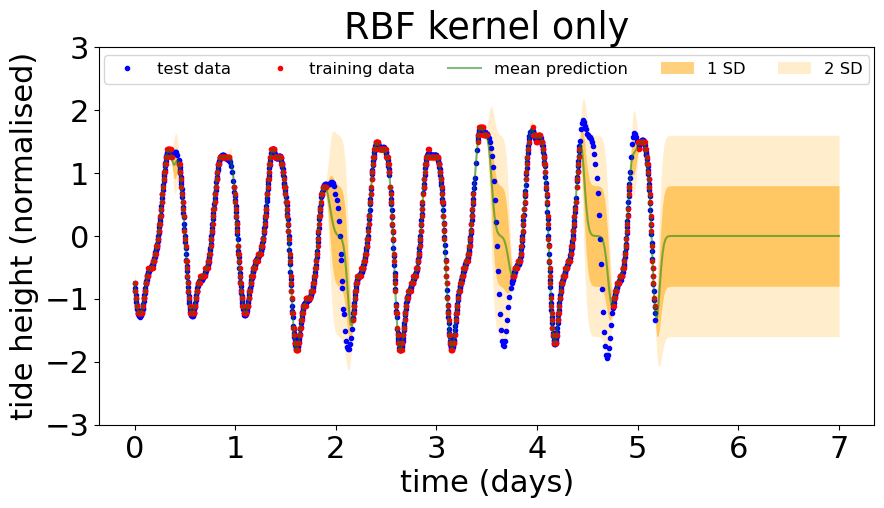

In [3]:

# Input data for GP
X = t
Y = y 
Xs = np.linspace(0, 7, 500).reshape(-1,1) 
# Xs = ttrue


jitter = 0.1

# Initial guess for model parameters
sigma_rbf = 0.8 # RBF kernel
L_rbf = 0.04

sigma_per = 0  # periodic kernel disabled
L_per = 1.0
p_per = 1.0

# Build the kernel function
params = [sigma_rbf, L_rbf, sigma_per, L_per, p_per]
kernel = buildKernel(params, jitter)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
title = 'RBF kernel only'
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue, title=title)



## **RBF plus periodic kernel** 

Could not compute RMSE: unequal input sizes
Log marginal likelihood: 570.7737862735977
RMSE:  0





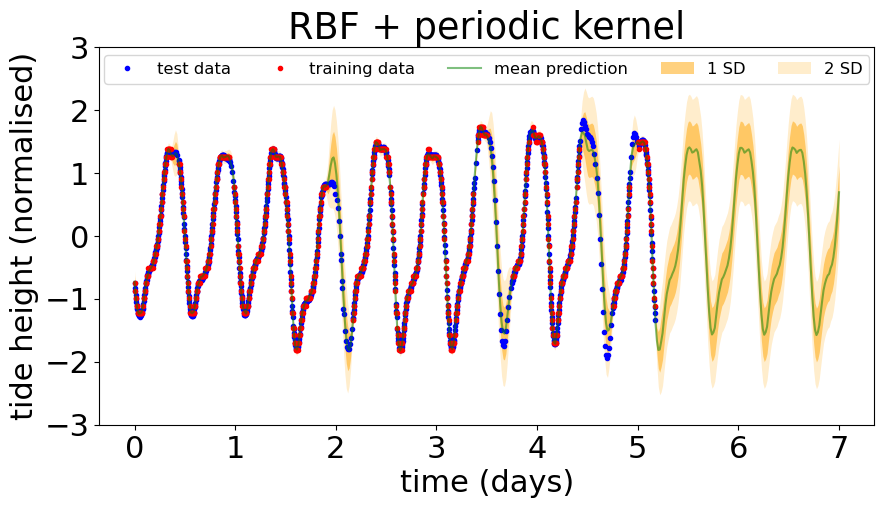

In [4]:
# Input data for GP
X = t
Y = y 
Xs = np.linspace(0, 7, 500).reshape(-1,1) 
# Xs = ttrue

jitter = 0.1

# Initial guess for model parameters
sigma_rbf = 0.4 # RBF kernel
L_rbf = 0.04

sigma_per = 10  # periodic kernel
L_per = 0.1
p_per = 0.5175

# Build the kernel function
params = [sigma_rbf, L_rbf, sigma_per, L_per, p_per]
kernel = buildKernel(params, jitter)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
title = 'RBF + periodic kernel'
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue, title=title)

## **Hyperparameter optimisation**

         Current function value: -324.845612
         Iterations: 10
         Function evaluations: 125
         Gradient evaluations: 18
initial guess:  [0.43834689052037257, -0.18970975541514404, 9.570860795184855, -0.07074981146569201, 0.5175]
final parameters: 0.43834689052037257,-0.0855821264803283,9.570860795184855,-1.6952733583954929,0.6918959052388933
Could not compute RMSE: unequal input sizes
Log marginal likelihood: -273.21255294227865
RMSE:  0





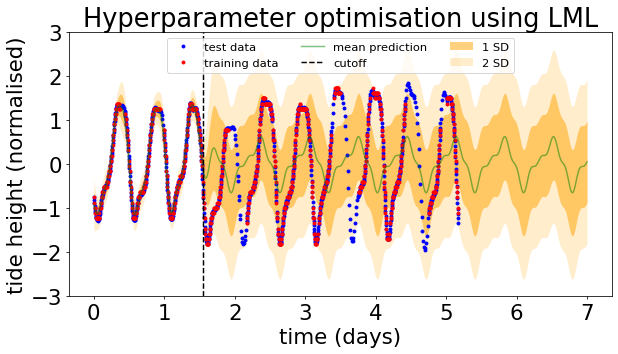

In [4]:
# Input data for GP
X = t
Y = y 
Xs = np.linspace(0, 7, 500).reshape(-1,1) 

# Portion of the data to use in optimisation
time_cutoff = 0.2 # 1.0 = use all data
Xc, Yc = truncateData(X, Y, time_cutoff)

# Initial gues s for model parameters
sigma_rbf = 0.8 # RBF kernel
L_rbf = 0.04

sigma_per = 10  # periodic kernel
L_per = 0.1
p_per = 0.5175

# Added jitter for numerical stability
jitter = 0.1 # 0.1 works for small training data, 0.01 for larger

# Randomise parameters before running optimisation
# (randomised component on top of the hand-tuned)
r = lambda x : x + 0.5*(random()*2 - 1)
init_guess = [r(sigma_rbf), r(L_rbf), r(sigma_per), r(L_per), p_per]

# Perform optimisation
max_iter = 10
result = minimize(
            optimizerFunction, 
            init_guess, 
            args=(Xc, Yc, Xs, jitter), 
            method='BFGS', 
            tol=0.01,
            options={"maxiter":max_iter, "disp":True}
            )


print("initial guess: ", init_guess)
print("final parameters: ", end='')
print(*result.x, sep=',')

# Build the kernel function
params = result.x
kernel = buildKernel(params, jitter)

# Posterior predictive distribution
jitter = params[0]
mu, sigma, LML = getPosteriorPredictive(Xc, Yc, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
title = 'Hyperparameter optimisation using LML'
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue, time_cutoff, title=title)

## Look-ahead experiments

We choose some lookahead time $\delta_t$. Then, for each available data point at time $t$ in the ground truth dataset, we try to predict its value using only data from before time $t - \delta_t$.

Finished iteration 100 of 1258
Finished iteration 200 of 1258
Finished iteration 300 of 1258
Finished iteration 400 of 1258
Finished iteration 500 of 1258
Finished iteration 600 of 1258
Finished iteration 700 of 1258
Finished iteration 800 of 1258
Finished iteration 900 of 1258
Finished iteration 1000 of 1258
Finished iteration 1100 of 1258
Finished iteration 1200 of 1258





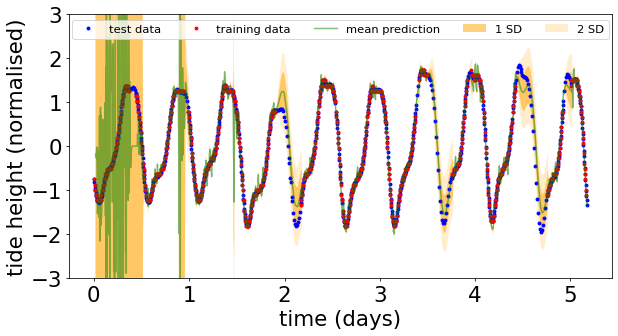

In [13]:
# Lookahead period in minutes
lookahead = 15
dt = lookahead / (60 * 24) # days

# Total available data
pts = len(ttrue)

# Start predicting from the nth datapoint onwards
first = 1

# Plotting arrays
tvals = ttrue[first-1:]
yvals, muvals, sigmavals, Xsvals= np.array([]), np.array([]), np.array([]), np.array([])

# Progress printing
pskip = 100

# Predict tide height at each time t based only on data from time t-dt or earlier
for i in range(first-1, pts):

    # Progress printout
    iter = i - first + 1
    if iter > 0 and iter % pskip == 0:
        print("Finished iteration", i-first+1, "of", pts-first+1)
    
    # Time to predict for
    target_time = ttrue[i]

    # Find latest data point to use for lookahead
    j = 0
    while j < len(t) and t[j] + dt < target_time:
        j += 1

    # Too early in dataset to look ahead - skip
    if ttrue[i] < dt or j == 0: 
        continue 

    # Extract data used for lookahead
    X = t[:j]
    Y = y[:j]

    # Target X* is a single point
    Xs = np.array([target_time])

    # Build kernel
    jitter = 0.01
    params = [0.4, 0.04, 10, 0.1, 0.5175]
    kernel = buildKernel(params, jitter)

    # Posterior predictive distribution
    mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

    # Store variables for plotting
    ii = i - first + 1
    muvals = np.append(muvals, mu)
    sigmavals = np.append(sigmavals, sigma)
    Xsvals = np.append(Xsvals, Xs)

# For the covariance matrix, we are interested in the diagonal terms only 
sigma_matrix = np.diag(sigmavals)

# Visualisation
title = 'Lookahead ' + str(lookahead) + ' minutes'
plotTides(Xsvals, muvals, sigma_matrix, t, y, ttrue, ytrue)

